University of Zagreb, Faculty of Electrical Engineering and Computing

## Imagination or Recollection? Discovering Differences in Cognitive Experience through Data Science


#### Fani Sentinella-Jerbić, 2022


Exploratory Data Analysis performed on [Hippocorpus](https://msropendata.com/datasets/0a83fb6f-a759-4a17-aaa2-fbac84577318) - a dataset of 6,854 English diary-like short stories about recalled and imagined events.




In [227]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graph plotting
import seaborn as sns # beautify plots
import sklearn # machine learning
import matplotlib.pyplot as plt
import warnings
#import spacy

## Explanatory data analysis

In [228]:
df = pd.read_csv('hcV3-stories.csv')
stories = pd.read_csv('hippoCorpusV2.csv')
stories.shape

(6854, 23)

In [229]:
stories.columns.values 

array(['AssignmentId', 'WorkTimeInSeconds', 'WorkerId', 'annotatorAge',
       'annotatorGender', 'annotatorRace', 'distracted', 'draining',
       'frequency', 'importance', 'logTimeSinceEvent', 'mainEvent',
       'memType', 'mostSurprising', 'openness', 'recAgnPairId',
       'recImgPairId', 'similarity', 'similarityReason', 'story',
       'stressful', 'summary', 'timeSinceEvent'], dtype=object)

Text(0.5, 0, '')

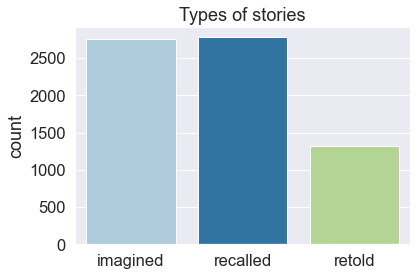

In [230]:
sns.set(font_scale = 1.5)
sns.set_style("darkgrid")
sns.countplot(x="memType", data=stories, palette=sns.color_palette("Paired"))
plt.title('Types of stories')
plt.xlabel('')

In [231]:
stories[['mostSurprising', 'mainEvent']].head(8)

,mostSurprising,mainEvent
0,when I got concert tickets,attending a show
1,we saw the beautiful sky.,a concert.
2,she went into labor early,my sister having her twins a little early
3,finding out they were healthy.,meeting my twin niece and nephew.
4,When I don't answer the phone in case I owe th...,the consequences of going to burning man
5,that I had to borrow money from Quickstep.,about my journey this year to Burning Man meta...
6,Lynn pinched Eric's rear and his reaction.,a scary car ride where we swerved on our way t...
7,we got pulled over the cops because of our dri...,a bad driving experience on the way to Acadia ...


In [232]:
stories['annotatorAge'].mean()

33.5535060752452

In [233]:
stories['annotatorGender'].value_counts()

woman         3422
man           3363
na              31
nonBinary       23
transman        10
other            3
transwoman       2
Name: annotatorGender, dtype: int64

In [234]:
stories['annotatorRace'].value_counts()

white            5044
black             690
hisp              395
asian             390
other             162
na                 63
indian             44
native             43
middleEastern      13
islander           10
Name: annotatorRace, dtype: int64

The dataset contains lots of information which doesn't really contribute to the aim of this seminar. I'm dropping them.

In [235]:
stories = stories.drop(columns=['annotatorAge','annotatorGender', 'annotatorRace'])
stories = stories.drop(columns=['AssignmentId', 'WorkerId', 'recImgPairId', 'recAgnPairId'])

In [236]:
counts_by_features = stories.isna().sum()
features_with_na = counts_by_features[counts_by_features > 0]
features_with_na

frequency           2756
importance           144
similarity          4098
similarityReason    4098
dtype: int64

In [237]:
stories['frequency'] = stories['frequency'].fillna(0)
stories['importance'] = stories['importance'].fillna(0)

In [238]:
def countplot(ax, df, x):
    sns.set(font_scale = 2)
    sns.countplot(ax=ax, data=df, x=x, hue='memType', palette=sns.color_palette("Paired"))
    
def plots(df, features, func=countplot):
    tot = len(features)
    cols = 3
    rows = tot // cols + tot % cols
    position = range(1,tot + 1)
    
    fig = plt.figure(figsize=(20,10))
    i = 0
    for k in range(tot):
        ax = fig.add_subplot(rows, cols, position[k])
        func(ax, df, x=features[i])
        i += 1
    plt.tight_layout()
    plt.show()

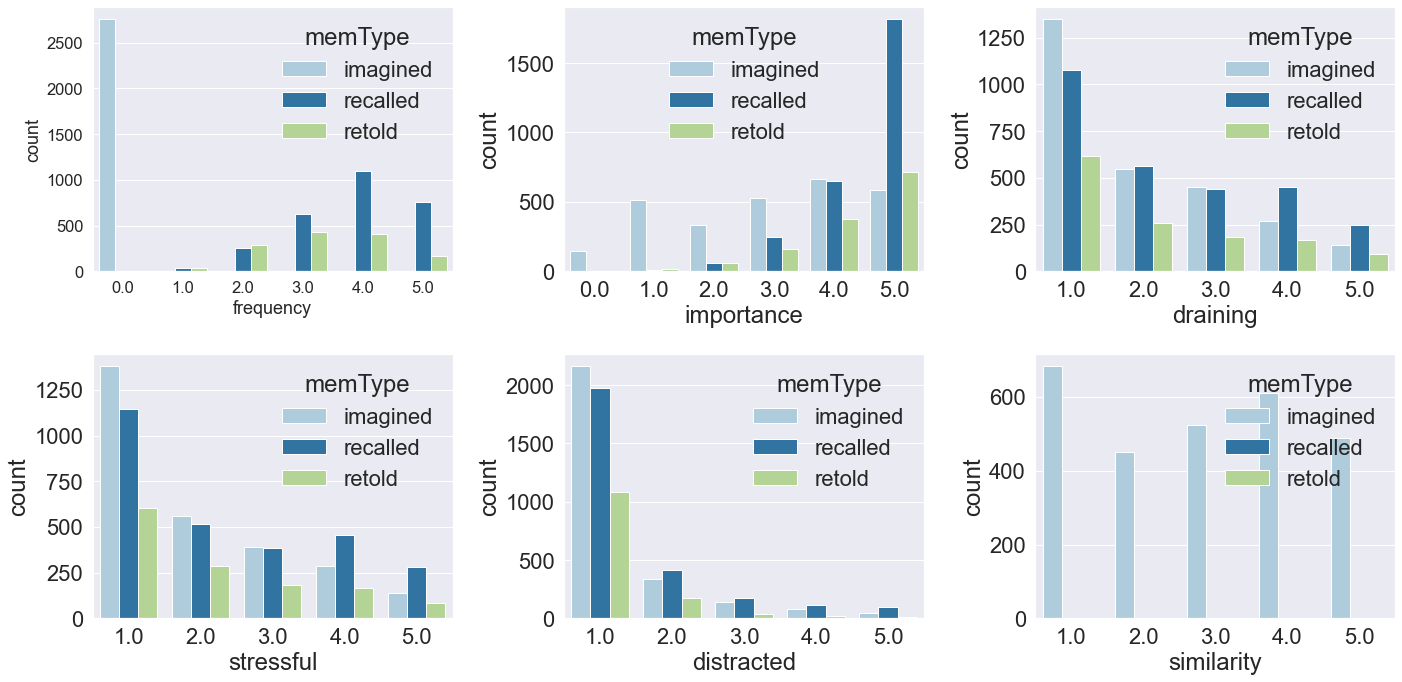

In [239]:
plots(stories, ['frequency', 'importance', 'draining', 'stressful', 'distracted', 'similarity'])

Although somewhat interesting, these features are very predictable and not available for most of texts "in the wild". I would like to obtain information only from the stories.

## Feature extraction

In [240]:
stories = stories[['story', 'memType']]
stories.head(10)

,story,memType
0,"Concerts are my most favorite thing, and my bo...",imagined
1,"The day started perfectly, with a great drive ...",recalled
2,It seems just like yesterday but today makes f...,imagined
3,"Five months ago, my niece and nephew were born...",recalled
4,About a month ago I went to burning man. I was...,imagined
5,Burning Man metamorphoses was perfect. I am de...,recalled
6,"Play stupid games, win stupid prizes road trip...",imagined
7,"Dear Diary,I would say this happened about 3 m...",recalled
8,I wanted to write about one of the best days i...,imagined
9,Me and my girlfriend had gone to the Los Angel...,retold


In [241]:
retold = stories[stories['memType'] == 'retold']
stories = stories.drop(retold.index)

In [242]:
stories['memType'] = np.where(stories['memType'] == 'recalled', 0, 1)
y = stories['memType']

In [243]:
stories.head()

,story,memType
0,"Concerts are my most favorite thing, and my bo...",1
1,"The day started perfectly, with a great drive ...",0
2,It seems just like yesterday but today makes f...,1
3,"Five months ago, my niece and nephew were born...",0
4,About a month ago I went to burning man. I was...,1


In order to achieve that I need to extract some features from the stories. 

In [245]:
import spacy
import text2emotion as te

nlp = spacy.load("en_core_web_sm")

def lexical(df):
    df['length'] = df['story'].str.len()
    df['split'] = df['story'].str.lower().str.split()
    df['word count'] = len(df['split'])
    df = selfrefs(df)
    df = ners(df)
    return df

def selfrefs(df):
    selfrefs = []
    for i in range(0, df.shape[0]):
        storyarr = df['split'].iloc[i]
        countI = storyarr.count('i')
        countMe = storyarr.count('me')
        countMy = storyarr.count('my')
        count = countI + countMe + countMy
        selfrefs.append(count)
    df['selfRef'] = selfrefs
    return df

def emotions(df):
    emots = []
    for i in range(0, df.shape[0]):
        story = df['story'].iloc[i]
        score = sum(te.get_emotion(story).values())
        emots.append(score)
    df['emotions'] = emots 
    return df

def ners(df):
    ners = []
    for i in range(0, df.shape[0]):
        story = df['story'].iloc[i]
        doc = nlp(story)
        count = len(doc.ents)
        ners.append(count)
    df['ner'] = ners
    return df

stories = lexical(stories)
retold = lexical(retold)

In [246]:
stories.to_csv('stories-lex.csv')
retold.to_csv('stories-lex.csv')

## Statistical testing

In [247]:
stories.groupby('memType').describe()

length                                                           \
          count         mean         std    min     25%     50%      75%   
memType                                                                    
0        2779.0  1432.454480  466.782603  604.0  1091.0  1360.0  1698.50   
1        2756.0  1253.879173  454.338395  600.0   922.0  1188.0  1486.25   

                word count          ... selfRef           ner            \
            max      count    mean  ...     75%   max   count      mean   
memType                             ...                                   
0        2999.0     2779.0  5535.0  ...    26.0  68.0  2779.0  7.046779   
1        2999.0     2756.0  5535.0  ...    24.0  78.0  2756.0  5.548621   

                                             
              std  min  25%  50%  75%   max  
memType                                      
0        4.959153  0.0  4.0  6.0  9.0  45.0  
1        4.371683  0.0  3.0  4.0  7.0  41.0  

[2 rows x 32 columns]

In [445]:
from scipy import stats
import statsmodels.api as sm
sns.set(font_scale = 1)

def pvalue_msg(pvalue, alpha):
    return ' ' if pvalue > alpha else ' not '

def t_test(data, feature, alpha):
    fe = stories[feature]
    fe0 = fe[data['memType']==0]
    fe1 = fe[data['memType']==1]
    
    print('NORMALITY SHAPIRO')
    p = stats.shapiro(fe0).pvalue
    print(f'sample is{pvalue_msg(p, alpha)}normally distributed, pvalue={p}')
    p = stats.shapiro(fe1).pvalue
    print(f'sample is{pvalue_msg(p, alpha)}normally distributed, pvalue={p}\n')
    
    print('NORMALITY DAGOSTINOS K2')
    p = stats.shapiro(fe0).pvalue
    print(f'sample is{pvalue_msg(p, alpha)}normally distributed, pvalue={p}')
    p = stats.shapiro(fe1).pvalue
    print(f'sample is{pvalue_msg(p, alpha)}normally distributed, pvalue={p}\n')
    
    print('HOMOGENEITY LEVENE')
    pl = stats.levene(fe0, fe1).pvalue
    print(f'variances are{pvalue_msg(pl, alpha)}homogenous, pvalue={pl}\n')
    
    print('HOMOGENEITY BARTLETT')
    pb = stats.bartlett(fe0, fe1).pvalue
    print(f'variances are{pvalue_msg(pb, alpha)}homogenous, pvalue={pb}\n')
    
    equalvars = pl > alpha or pb > alpha
    
    sns.displot(kde=True, data=data, x=feature, hue="memType", multiple="stack", palette=sns.color_palette("Paired", n_colors=2))
    plt.title('HISTOGRAM AND DENSITY PLOT')
    plt.show()
    
    fig, (ax0, ax1) = plt.subplots(1,2)
    plt.suptitle('QQ-PLOTS')
    fe0z = stats.zscore(fe0)
    sm.qqplot(fe0z, line='45', markerfacecolor='#3274a1', markeredgecolor='#3274a1', ax=ax0)
    ax0.set_title('recalled')
    
    fe1z = stats.zscore(fe1)
    sm.qqplot(fe1z, line='45', markerfacecolor='#3274a1', markeredgecolor='#3274a1', ax=ax1)
    ax1.set_title('imagined')
    
    fig.tight_layout()
    plt.show()
    
    p = stats.ttest_ind(fe0, fe1, equal_var=equalvars).pvalue
    
    print('TWO SAMPLE T-TEST')
    print(f'stories do{pvalue_msg(p,alpha)}statistically differ in terms of mean {feature}, pvalue={pl}')

### Length

NORMALITY SHAPIRO
sample is not normally distributed, pvalue=3.5448673778628755e-28
sample is not normally distributed, pvalue=3.65734672431368e-32

NORMALITY DAGOSTINOS K2
sample is not normally distributed, pvalue=3.5448673778628755e-28
sample is not normally distributed, pvalue=3.65734672431368e-32

HOMOGENEITY LEVENE
variances are not homogenous, pvalue=0.028778091687080346

HOMOGENEITY BARTLETT
variances are homogenous, pvalue=0.15532383208801123



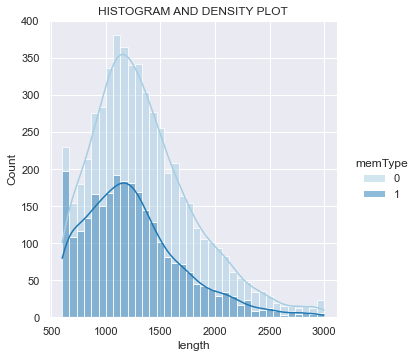

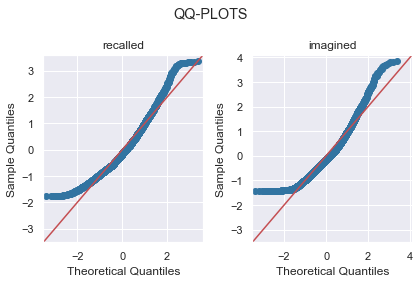

TWO SAMPLE T-TEST
stories do not statistically differ in terms of mean length, pvalue=0.028778091687080346


In [446]:
from scipy import stats
t_test(stories, 'length', 0.05)

### Self refreneces

NORMALITY SHAPIRO
sample is not normally distributed, pvalue=8.789534748765922e-24
sample is not normally distributed, pvalue=1.0345449319158895e-26

NORMALITY DAGOSTINOS K2
sample is not normally distributed, pvalue=8.789534748765922e-24
sample is not normally distributed, pvalue=1.0345449319158895e-26

HOMOGENEITY LEVENE
variances are not homogenous, pvalue=0.01120097138450681

HOMOGENEITY BARTLETT
variances are homogenous, pvalue=0.05765453573361728



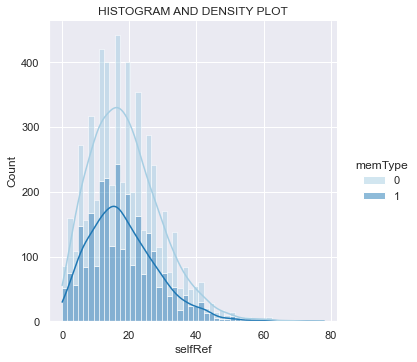

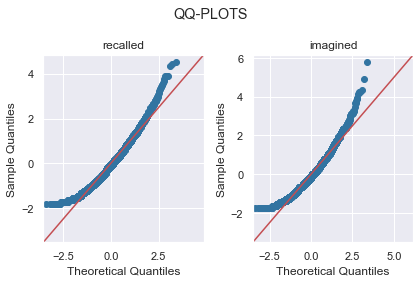

TWO SAMPLE T-TEST
stories do not statistically differ in terms of mean selfRef, pvalue=0.01120097138450681


In [449]:
t_test(stories, 'selfRef', 0.05)

### Named entities

NORMALITY SHAPIRO
sample is not normally distributed, pvalue=1.309933804450839e-41
sample is not normally distributed, pvalue=0.0

NORMALITY DAGOSTINOS K2
sample is not normally distributed, pvalue=1.309933804450839e-41
sample is not normally distributed, pvalue=0.0

HOMOGENEITY LEVENE
variances are not homogenous, pvalue=4.398978499226898e-08

HOMOGENEITY BARTLETT
variances are not homogenous, pvalue=3.560413859517069e-11



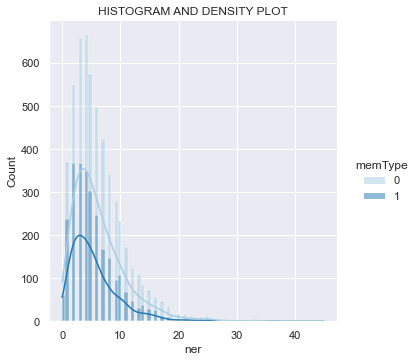

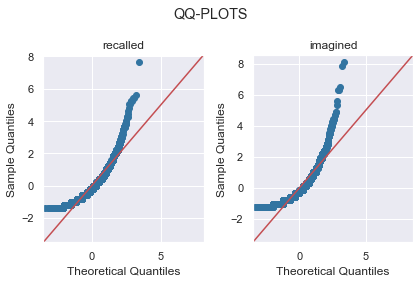

TWO SAMPLE T-TEST
stories do not statistically differ in terms of mean ner, pvalue=4.398978499226898e-08


In [450]:
t_test(stories, 'ner', 0.05)

In [ ]:
X = stories.drop(columns=['memType', 'story', 'split'])
X_retold = retold.drop(columns=['memType', 'story', 'split'])
X.head()

## Machine Learning
I'm going to train a machine learning model to classify stories into imagined and recalled. Then I'll ask the model to predict whether recalled stories are imagined or recalled. This could explain narrativization of recalled events.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=5)

## Choosing models & hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
def grid_search(model, params, X, y):
    model = GridSearchCV(model, params, n_jobs=-1)
    model.fit(X, y)
    return model

### Logistic regression

In [ ]:
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
hp = {
        'solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'penalty': ['none', 'l1', 'l2', 'elasticnet'],
        'C': [0.1, 1, 10, 100],
}
lr = grid_search(LogisticRegression(), hp, X_train, y_train).best_params_

### K-neighbors classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
hp = {
        'n_neighbors': list(range(1, 15)),
        'weights': ['uniform', 'distance'],
        'metric': ['minkowski', 'euclidean', 'manhattan']
}
knn = grid_search(KNeighborsClassifier(), hp, X_train, y_train).best_params_

In [ ]:
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

table = ['Algorithm', 'Fold1', 'Fold2', 'Fold3', 'Average']

def cross_validate(X, y, models):
    cv = KFold(n_splits=3, random_state=5, shuffle=True)
    all_rows = []
    for m in models:
        row = []
        row.append(type(m).__name__)
        print(type(m).__name__)
        scores = cross_val_score(m, X, y, cv=cv, n_jobs=-1, scoring='accuracy')
        if "GridSearchCV" == type(m).__name__:
            print(m.fit(X).best_params_)
        for score in scores:
            row.append(score)
        row.append(sum(scores)/len(scores))
        all_rows.append(row)
    res = pd.DataFrame(all_rows, columns=table)
    display(res)


models = [LogisticRegression(**lr),
          KNeighborsClassifier(**knn),
          SVC(),
          DecisionTreeClassifier(),
          RandomForestClassifier()
         ]
cross_validate(X_train, y_train, models)

In [ ]:
LogisticRegression(**lr).fit(X_train,y_train).predict(X_retold).mean()

In [ ]:
bla = te.get_emotion("About a month ago I went to burning man. I was having a hard time in my life and felt like I needed a break. So I went to burning man. I had a lot of fun and met some friends. But now after it is done I'm having financial problems. My bills keep coming and I owe people. Including my new friends. Everyday bills come and new bills come in the mail. I always look at the caller ID now on my phone, just in case. if I owe them money I don't want to answer. Everyday it feels like I made a mistake by letting myself spend all my money. I have to work extra hours but they won't give me any. So the bills just keep piling up and I need to search around for a second job. I barely have enough time for the first one. I really should have thought about what would have happened in advance.")
bla['Happy']
sum(bla.values())